# An analysis of restaurants listed on a food delivery app Foodpanda

### Introduction 
For this project, I am analysing the restaurant data available on foodpanda pakistan, to try and figure out the most popular cuisines and dishes in Pakistani cities. To start with, I am only fetching data from Karachi and Lahore, the analysis will later be conducted for all the cities in Pakistan. Foodpanda is a good jumping of point to start collecting citywise restaurant data as it has the largest number of restaraunt merchants on their platform.<p>
I hope to open a restaurant one day and i feel that utilizing the outputs of this project, i will be able to understand market opportunities in Pakistan's cities. Unfortunately, we are unable to get customer order data, which really help hone in on an optimum restaurant and menu strategy. Nontheless, this project should still enable to get an understanding of the overall market and greatly aid in market research, while i search for other sources to enrich the collected data.


#### Ethical considerations
The data I am extracting is public information on listed businesses, we are not extracting any PII. However, the data may be considered somewhat propreitary as we are scrapping the user ratings of the restaurant, which belong to foodpanda.

In [1]:
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
import json
import requests
import time
import random
#from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

# Data Collection

I will be scraping the foodpanda website (https://www.foodpanda.pk/). For the purposes of this proposal,d we are primarily interested in two types of pages on the website.


1.   City Page= Which lists all the restaurants in a given city
                The url of city pages is in the following format:
                https://www.foodpanda.pk/city/karachi
                base url+page_type(City/)+City_name(karachi)

2.   Restaurant Page= Each Restaurants page within a City page
                https://www.foodpanda.pk/restaurant/jtds/food-bank-1
                base url+page_type(restaurant/)+Restaurant_Code+Restaurant name(food bank 1)


## Get Page Function
The below get_page function uses the get function to send a GET request to the specified url.     
<p>
Since we want to reuse this function for both types of pages, the function takes as input, the base url(site_url), the type of page(facility_type), the name of city or restaurant(facility_name) and the restaurant code (facility_code).</br>
<p>
 The Facility code is only relevant for fetching restaurant data, so if a restaurant code is passed in to the function, the if statement is used to determine the nature of request, and constructs the appropriate url to fetch the data.</br>


In [2]:
def get_page(
    site_url=None,
    facility_type=None,
    facility_name=None,
    facility_code=None
):
    site_url = site_url
    facility_type = facility_type
    facility_name = facility_name

    if facility_code:
        facility_code = facility_code
        r = requests.get(site_url+facility_type+facility_code +
                         facility_name, headers={'User-Agent': 'Mozilla/5.0'})
    else:
        r = requests.get(site_url+facility_type+facility_name,
                         headers={'User-Agent': 'Mozilla/5.0'})
   # print(r)
    return r

## Get Tag contents as string function
The below function, takes a Beautiful Soup, soup object as input and fetches all the instances of the specified tag as a string, if we are interested in a particular tag, the index number of the specific tag can be passed in to the parameters to fetch only that instance.

In [3]:
def get_tag_contents_as_string(
    soup,
    tag_index=None,
    tag_type=None,
):
    tag = soup.find_all(tag_type)[tag_index]
    tag_string = tag.string

    return tag_string

## String to Json function
The below function, takes takes a string as input and converts it into a Json object called json_obj

In [4]:
def string_to_json(
    string
):
    json_obj = json.loads(string)

    return json_obj

## Get City Restaurant Function
The below function fetches all the listed restaurants on a given cities listing page. It takes as input the city name, uses the get page function to fetch the relevant cities' page</br>


The function then creates a beautiful soup object of the response. From visual inspection of the source code of the page, we can see that the 14th Script tag contains a json obj with data for all the restaurants in the city. 
<p>
The get_tag_contents_as_string fuction is then called with the index parameter of 14 (since we want to fetch the 14th script tag) to fetch the relevant tag as a string. </br>
Since the tag has 109 extra characters at the beginning and 69 at the end, the extra characers are stripped out and the remaining string is converted in to a json object.
<p>
The json is then normalized using the pd.json_normalize() function. Extraneous columns are dropped, and the data is stored in a pandas dataframe.
<p>


In [5]:
def get_city_restaraunts_data_frame(
    city_name,
    site_url="https://www.foodpanda.pk/",
    city_url="city/",
    rest_url="restaurant/"
):

    r = get_page(
        site_url=site_url,
        facility_type=city_url,
        facility_name=city_name,
        facility_code=None
    )

    soup = bs(r.text, 'html.parser')


    script_index = 14
    script_string = get_tag_contents_as_string(
        soup=soup,
        tag_type='script',
        tag_index=script_index,
    )
    print(script_string)
    start_index = 109
    from_end_index = -69
    city_state_initial = script_string[start_index:from_end_index]

    json_obj = string_to_json(
        city_state_initial
    )

    rest_data = pd.json_normalize(json_obj)

    columns_to_drop = ['imageLowResolution', 'imageHighResolution']

    columns_to_add = ["lat", "long", "street_address"]
    rest_data = rest_data.drop(columns_to_drop, axis=1)
    rest_data = pd.concat([rest_data, pd.DataFrame(columns=columns_to_add)])

    return rest_data
  #  print(rest_data)

### List of column names for data frame is created

In [6]:
   column_names = [
        'id',
        'city',
        'code',
        'name',
        'urlKey',
        'budget',
        'tag',
        'tags',
        'rating',
        'reviewNumber',
        'discounts',
        'is_premium',
        'is_promoted',
        'chain.id',
        'chain.name',
        'chain.url_key',
        'chain.is_accepting_global_vouchers',
        'chain.code',
        'chain.main_vendor_code',
        'characteristics.cuisines',
        'characteristics.food_characteristics',
        'characteristics.primary_cuisine.id',
        'characteristics.primary_cuisine.name',
        'characteristics.primary_cuisine.url_key',
        'characteristics.primary_cuisine.main',
        
    ]

### Empty Data frame is created with the above columns

In [7]:
    city_wise_rest_dataframe = pd.DataFrame(
        columns=column_names)

### List of cities for which restaurant data is to be pulled
Limiting to islamabad and lahore for now. All Pakistani cities to be fetched at a later point.

In [8]:
    list_of_cities = [
        "islamabad",
        "lahore"
    ]

## Parsing and saving data in a Dataframe
The below for loop iterates through the list of cities in the above list and uses the get_city_restaraunts_data_frame function to fetch data and create a dataframe for each city. The city dataframes are then concatenated to create a data set with all the restaurants in all the cities. 

In [9]:
for city_name in list_of_cities:

        city_dataframe = get_city_restaraunts_data_frame(city_name)
        city_dataframe = city_dataframe.assign(city=city_name)

        city_wise_rest_dataframe = pd.concat(
            [city_wise_rest_dataframe, city_dataframe],
            axis=0,
            ignore_index=True
        )


        window.VOLO = window.VOLO || {};
        VOLO.CityPageInitialState = {
            vendorListState: [{"id":63528,"code":"h0fi","chain":{"id":null,"name":"","url_key":"","is_accepting_global_vouchers":null,"code":"","main_vendor_code":""},"name":"Won Ton","urlKey":"won-ton","characteristics":{"cuisines":[{"id":89,"name":"Non-alcoholic Drinks","url_key":"non-alcoholic-drinks","main":false},{"id":74,"name":"Chinese","url_key":"chinese","main":true}],"food_characteristics":[{"id":90,"name":"Soup","is_halal":false,"is_vegetarian":false},{"id":227,"name":"Ramadan Takeaway","is_halal":false,"is_vegetarian":false},{"id":84,"name":"Rice","is_halal":false,"is_vegetarian":false}],"primary_cuisine":{"id":74,"name":"Chinese","url_key":"chinese","main":true}},"imageLowResolution":"https:\/\/images.deliveryhero.io\/image\/fd-pk\/LH\/h0fi-listing.jpg?width=400&height=208","imageHighResolution":"https:\/\/images.deliveryhero.io\/image\/fd-pk\/LH\/h0fi-listing.jpg?width=800&height=416","budget"


        window.VOLO = window.VOLO || {};
        VOLO.CityPageInitialState = {
            vendorListState: [{"id":52136,"code":"l6qd","chain":{"id":null,"name":"","url_key":"","is_accepting_global_vouchers":null,"code":"","main_vendor_code":""},"name":"City Juice Bar","urlKey":"city-juice-bar","characteristics":{"cuisines":[{"id":89,"name":"Non-alcoholic Drinks","url_key":"non-alcoholic-drinks","main":true},{"id":73,"name":"Pizza","url_key":"pizza","main":false}],"food_characteristics":[{"id":227,"name":"Ramadan Takeaway","is_halal":false,"is_vegetarian":false},{"id":230,"name":"Takeaway Eid","is_halal":false,"is_vegetarian":false}],"primary_cuisine":{"id":89,"name":"Non-alcoholic Drinks","url_key":"non-alcoholic-drinks","main":true}},"imageLowResolution":"https:\/\/images.deliveryhero.io\/image\/fd-pk\/LH\/l6qd-listing.jpg?width=400&height=208","imageHighResolution":"https:\/\/images.deliveryhero.io\/image\/fd-pk\/LH\/l6qd-listing.jpg?width=800&height=416","budget":2,"tag":"","tags"

In [10]:
print(city_wise_rest_dataframe)

          id       city  code                                     name  \
0    63528.0  islamabad  h0fi                                  Won Ton   
1    63938.0  islamabad  vtfl                               JUICE TIME   
2    10706.0  islamabad  t4as  The Coffee Bean & Tea Leaf - F11 Markaz   
3    61854.0  islamabad  en15                                  Roadies   
4    23489.0  islamabad  n0rj                     Lebanese Food Garden   
..       ...        ...   ...                                      ...   
592  68552.0     lahore  wzwp                             Amigos Grill   
593  60745.0     lahore  itgb                          Usman Fast Food   
594  66413.0     lahore  nkao                                GOOD BITE   
595  64032.0     lahore  b0ox                                 Khilji's   
596  49235.0     lahore  r0kt                     Farzanas Kitchenette   

                                  urlKey  budget               tag  \
0                                won-ton 

In [11]:
# Dataframe is saved as a CSV 
city_wise_rest_dataframe.to_csv('rest_data.csv',index=False)


# Getting additional data
Each restaurant page has some additional data, which is not available in the city level json object. In particular, we want to fetch the postal address and lat. long. of each restaurant.</br>
Each restaurants page has an SEO script which contains the the data we need in a json object.<p></br>
## Get Restaurant Metadata function.
The below function takes into input the features needed to construct each restaurants link, sends a request to the relevant page using the get page() function.</br>
Soup object is created with the request response. Since the SEO script is the first script tage, we pass through script_index=0 and fetch the first 'script' tag type. There are not extra characters in this response, so the string is returned as is.</br>
The string is then converted to a json object. Each restaurants 'code' is added as a column to the data frame to allow us to easily merge the two data frames later.

In [12]:
def get_restaraunts_meta_data(
    site_url="https://www.foodpanda.pk/",
    facility_type="restaurant/",
    facility_name=None,
    facility_code=None,
    columns_to_keep=None
):
    r = get_page(
        site_url=site_url,
        facility_type=facility_type,
        facility_name=facility_name,
        facility_code=facility_code
    )

    soup = bs(r.text, 'html.parser')

    script_index = 0
    script_string = get_tag_contents_as_string(
        soup=soup,
        tag_type='script',
        tag_index=script_index,
    )

    json_obj = string_to_json(
        script_string
    )
    
    json_obj['code']=facility_code
    
    
    rest_data = pd.json_normalize(json_obj)
    #columns_to_keep = [
    #    '@id',
    #   'address.streetAddress',
    #    'address.addressLocality',
    #    'geo.latitude',
    #    'geo.longitude',
    #    'potentialAction.priceSpecification.price'
    #]

    rest_data = rest_data[columns_to_keep]

    return rest_data

In [13]:
    # Load CSV as a dataframe names foodpanda_dataframe
    # foodpanda_dataframe = ...
    foodpanda_dataframe=pd.read_csv('rest_data.csv')
    #Since fetching all the restaurant data will take a long time, the below variable will limit the number of requests to 5,
    #to pull the full data 
    start_row=10
    end_row=15
    foodpanda_dataframe_limited= foodpanda_dataframe[start_row:end_row]

### Create Empty dataframe for additional restaurant data 

In [14]:
columns_to_keep = [
        'code',
        '@id',
        'address.streetAddress',
        'address.addressLocality',
        'geo.latitude',
        'geo.longitude',
        'potentialAction.priceSpecification.price'
    ]
rest_meta_data = pd.DataFrame(
        columns=columns_to_keep
    )

## Fetch additional restaurant data
The below code creats an empty csv called rest_meta_data.csv. The utilizes a for look to recursively, go to each restaurants link and fetch the additional data in the SEO script. Each restaurants relevant data is appended to the csv file.</br>
In order to avoid overloading the server, I have added a random delay between 10 and 40 seconds in between each call.

# NOTE:
To ease in execution the below cell is limited to fetching data for 5 restaurants, to fetch data for all restaurants, un comment and execute the next cell.


In [15]:
time_low = 10
time_high = 40

rest_meta_data.to_csv("rest_meta_data2.csv")


for index, row in foodpanda_dataframe_limited.iterrows():#>>>>>>> use this to only fetch 5 records
#for index, row in foodpanda_dataframe.iterrows():  >>>>>use this to fetch full data  
      facility_code = row['code']+"/"
      facility_name= row['urlKey']
      print(f"{facility_code}")
      print(f"{facility_name}")

      try:
        rest_meta_data_single =get_restaraunts_meta_data(
          site_url="https://www.foodpanda.pk/",
            facility_type="restaurant/",
            facility_name=facility_name,
            facility_code=facility_code,
            columns_to_keep=columns_to_keep
          )
    #  rest_meta_data_single = rest_meta_data_single['code']
        
        rest_meta_data = pd.concat(
            [rest_meta_data, rest_meta_data_single],
            axis=0,
            ignore_index=True
        )
      #  print(rest_meta_data_single)
        rest_meta_data.to_csv('rest_meta_data2.csv', mode='a', header=False)
      except:
        continue        
    
      time.sleep(
        random.uniform(time_low, time_high)
          )

ffw1/
hang-cheng-f11
t5ea/
the-nutella-spot-f11-804
u7ro/
abbott-pizza
v2vf/
bg-s-pizza-plus
x6av/
karachi-naseeb-biryani-e-11


# Execute to fetch all Restaurant data

In [16]:
#time_low = 10
#time_high = 40
#
#rest_meta_data.to_csv("rest_meta_data.csv")
#
#

#for index, row in foodpanda_dataframe.iterrows():  >>>>>use this to fetch full data  
#      facility_code = row['code']+"/"
#      facility_name= row['urlKey']
#      print(f"{facility_code}")
#      print(f"{facility_name}")
#
#      try:
#        rest_meta_data_single =get_restaraunts_meta_data(
#          site_url="https://www.foodpanda.pk/",
#            facility_type="restaurant/",
#            facility_name=facility_name,
#            facility_code=facility_code,
#            columns_to_keep=columns_to_keep
#          )
#    #  rest_meta_data_single = rest_meta_data_single['code']
#        
#        rest_meta_data = pd.concat(
#            [rest_meta_data, rest_meta_data_single],
#            axis=0,
#            ignore_index=True
#        )
#      #  print(rest_meta_data_single)
#        rest_meta_data.to_csv('rest_meta_data.csv', mode='a', header=False)
#      except:
#        continue        
#    
#      time.sleep(
#        random.uniform(time_low, time_high)
#          )

In [17]:
#rest_meta_data.to_csv("restaurants_foodpanda.csv", index=False)

In [18]:
#rest_meta_data.to_csv('rest_meta_data.csv', mode='a', header=False)

### Load csv to data frame

In [19]:
 foodpanda_dataframe1=pd.read_csv('rest_meta_data2.csv')

In [20]:
#foodpanda_dataframe=pd.read_csv('rest_meta_data.csv') >>>>> WHEN USING FULL DATA

In [21]:
foodpanda_dataframe1

,Unnamed: 0,code,@id,address.streetAddress,address.addressLocality,geo.latitude,geo.longitude,potentialAction.priceSpecification.price
0,0,ffw1/,https://www.foodpanda.pk/restaurant/ffw1/hang-...,"Street 73, near Tariq Heights, F-11/1. Islamabad",Islamabad,33.680739,72.988165,496.50
1,0,ffw1/,https://www.foodpanda.pk/restaurant/ffw1/hang-...,"Street 73, near Tariq Heights, F-11/1. Islamabad",Islamabad,33.680739,72.988165,496.50
2,1,t5ea/,https://www.foodpanda.pk/restaurant/t5ea/the-n...,"Shop #, 7 Liberty Square Plaza F-11 Markaz Isl...",Islamabad,33.684047,72.986510,622.38
3,0,ffw1/,https://www.foodpanda.pk/restaurant/ffw1/hang-...,"Street 73, near Tariq Heights, F-11/1. Islamabad",Islamabad,33.680739,72.988165,496.50
4,1,t5ea/,https://www.foodpanda.pk/restaurant/t5ea/the-n...,"Shop #, 7 Liberty Square Plaza F-11 Markaz Isl...",Islamabad,33.684047,72.986510,622.38
5,2,u7ro/,https://www.foodpanda.pk/restaurant/u7ro/abbot...,Shop No 2 Capital Arcade Plot No.33 Pmchs Main...,Islamabad,33.696379,72.968491,425.11
6,0,ffw1/,https://www.foodpanda.pk/restaurant/ffw1/hang-...,"Street 73, near Tariq Heights, F-11/1. Islamabad",Islamabad,33.680739,72.988165,496.50
7,1,t5ea/,https://www.foodpanda.pk/restaurant/t5ea/the-n...,"Shop #, 7 Liberty Square Plaza F-11 Markaz Isl...",Islamabad,33.684047,72.986510,622.38
8,2,u7ro/,https://www.foodpanda.pk/restaurant/u7ro/abbot...,Shop No 2 Capital Arcade Plot No.33 Pmchs Main...,Islamabad,33.696379,72.968491,425.11
9,3,v2vf/,https://www.foodpanda.pk/restaurant/v2vf/bg-s-...,"Shop 3, L G Professional Arcade Plot 24, near ...",Islamabad,33.703889,72.980000,373.33


### Strip extra character from 'code' column in additional restaurant info data frame.
The restaurant codes have a '/' appended to them for the link, the below code strips the last character of each cell.

In [22]:
foodpanda_dataframe1['code'] = foodpanda_dataframe1['code'].map(lambda x: str(x)[:-1])

### Drop duplicate restaurants

In [23]:
foodpanda_dataframe1=foodpanda_dataframe1.drop_duplicates('code')

### Merge the two dataframes, with restaurant code as the matching key.

In [24]:
final_data=pd.merge(foodpanda_dataframe_limited,foodpanda_dataframe1, how="inner", on='code')
#final_data=pd.merge(foodpanda_dataframe,foodpanda_dataframe1, how="inner", on='code') # >>>>>>>>>> USE WHEN FULL DATA
final_data

,id,city,code,name,urlKey,budget,tag,tags,rating,reviewNumber,...,lat,long,street_address,Unnamed: 0,@id,address.streetAddress,address.addressLocality,geo.latitude,geo.longitude,potentialAction.priceSpecification.price
0,60799.0,islamabad,ffw1,Hang Cheng- F11,hang-cheng-f11,1.0,Discount 40%,"[{'code': 'DEAL', 'text': 'Discount 40%'}]",0.0,0.0,...,NaN,NaN,NaN,0,https://www.foodpanda.pk/restaurant/ffw1/hang-...,"Street 73, near Tariq Heights, F-11/1. Islamabad",Islamabad,33.680739,72.988165,496.50
1,12420.0,islamabad,t5ea,The Nutella Spot - F11,the-nutella-spot-f11-804,3.0,Top Rated,"[{'code': 'FREETEXT', 'text': 'Top Rated'}]",4.4,370.0,...,NaN,NaN,NaN,1,https://www.foodpanda.pk/restaurant/t5ea/the-n...,"Shop #, 7 Liberty Square Plaza F-11 Markaz Isl...",Islamabad,33.684047,72.986510,622.38
2,19917.0,islamabad,u7ro,Abbott Pizza,abbott-pizza,3.0,NaN,[],3.7,46.0,...,NaN,NaN,NaN,2,https://www.foodpanda.pk/restaurant/u7ro/abbot...,Shop No 2 Capital Arcade Plot No.33 Pmchs Main...,Islamabad,33.696379,72.968491,425.11
3,34308.0,islamabad,v2vf,Bg's Pizza Plus,bg-s-pizza-plus,3.0,NaN,[],3.6,6.0,...,NaN,NaN,NaN,3,https://www.foodpanda.pk/restaurant/v2vf/bg-s-...,"Shop 3, L G Professional Arcade Plot 24, near ...",Islamabad,33.703889,72.980000,373.33
4,53482.0,islamabad,x6av,Karachi Naseeb Biryani - E-11,karachi-naseeb-biryani-e-11,2.0,NaN,[],3.8,336.0,...,NaN,NaN,NaN,4,https://www.foodpanda.pk/restaurant/x6av/karac...,"Near Quetta Green Cafe, Sector E-11/3, Islamabad",Islamabad,33.703888,72.979502,346.67


### Delete extra columns

,id,city,code,name,urlKey,budget,tag,tags,rating,reviewNumber,...,characteristics.primary_cuisine.id,characteristics.primary_cuisine.name,characteristics.primary_cuisine.url_key,characteristics.primary_cuisine.main,@id,address.streetAddress,address.addressLocality,geo.latitude,geo.longitude,potentialAction.priceSpecification.price
0,60799.0,islamabad,ffw1,Hang Cheng- F11,hang-cheng-f11,1.0,Discount 40%,"[{'code': 'DEAL', 'text': 'Discount 40%'}]",0.0,0.0,...,86.0,Fast Food,fast-food,True,https://www.foodpanda.pk/restaurant/ffw1/hang-...,"Street 73, near Tariq Heights, F-11/1. Islamabad",Islamabad,33.680739,72.988165,496.50
1,12420.0,islamabad,t5ea,The Nutella Spot - F11,the-nutella-spot-f11-804,3.0,Top Rated,"[{'code': 'FREETEXT', 'text': 'Top Rated'}]",4.4,370.0,...,84.0,Desserts,desserts,True,https://www.foodpanda.pk/restaurant/t5ea/the-n...,"Shop #, 7 Liberty Square Plaza F-11 Markaz Isl...",Islamabad,33.684047,72.986510,622.38
2,19917.0,islamabad,u7ro,Abbott Pizza,abbott-pizza,3.0,NaN,[],3.7,46.0,...,73.0,Pizza,pizza,True,https://www.foodpanda.pk/restaurant/u7ro/abbot...,Shop No 2 Capital Arcade Plot No.33 Pmchs Main...,Islamabad,33.696379,72.968491,425.11
3,34308.0,islamabad,v2vf,Bg's Pizza Plus,bg-s-pizza-plus,3.0,NaN,[],3.6,6.0,...,73.0,Pizza,pizza,True,https://www.foodpanda.pk/restaurant/v2vf/bg-s-...,"Shop 3, L G Professional Arcade Plot 24, near ...",Islamabad,33.703889,72.980000,373.33
4,53482.0,islamabad,x6av,Karachi Naseeb Biryani - E-11,karachi-naseeb-biryani-e-11,2.0,NaN,[],3.8,336.0,...,139.0,Pakistani,pakistani,True,https://www.foodpanda.pk/restaurant/x6av/karac...,"Near Quetta Green Cafe, Sector E-11/3, Islamabad",Islamabad,33.703888,72.979502,346.67


### Save merged Dataframe as csv

In [26]:
final_data.to_csv('final_data_limited.csv')
#final_data.to_csv('final_data.csv') >>>>>USE FOR FULL DATA

# Loading the full data set

In [27]:
#final_dataframe=pd.read_csv('final_data_limited.csv')>>>> USE TO LOAD LIMITED DATA CSV
final_dataframe=pd.read_csv('final_data.csv')#>>>>>> Use for full data
final_dataframe

,Unnamed: 0,id,city,code,name,urlKey,budget,tag,tags,rating,...,lat,long,street_address,Unnamed: 0.1,@id,address.streetAddress,address.addressLocality,geo.latitude,geo.longitude,potentialAction.priceSpecification.price
0,0,54033.0,islamabad,c4kf,Cafeina Time,cafeina-time,3.0,NaN,[],2.5,...,NaN,NaN,NaN,0,https://www.foodpanda.pk/restaurant/c4kf/cafei...,"Cafeina Time City Center, D-12 Markaz islamabad",Islamabad,33.702587,72.948398,376.50
1,1,57557.0,islamabad,afjv,Rapido PIZZA & FAST FOOD,rapido-pizza-and-fast-food,3.0,NaN,[],4.1,...,NaN,NaN,NaN,1,https://www.foodpanda.pk/restaurant/afjv/rapid...,"Shop# 31, Ground floor, AlGhaffar Mall, G-11 M...",Islamabad,33.668834,72.998387,652.89
2,2,24444.0,islamabad,n9jb,Rahat Pizza – F-11,rahat-pizza-f-11,3.0,Discount 20%,"[{'code': 'DEAL', 'text': 'Discount 20%'}]",2.4,...,NaN,NaN,NaN,2,https://www.foodpanda.pk/restaurant/n9jb/rahat...,shop 1 select center plaza 2nd floor f11 markaz,Islamabad,33.684700,72.986450,370.91
3,3,68992.0,islamabad,g7f1,Desi Zaiqa,desi-zaiqa-g7f1,2.0,Flat 30% OFF,"[{'code': 'DEAL', 'text': 'Flat 30% OFF'}, {'c...",1.3,...,NaN,NaN,NaN,3,https://www.foodpanda.pk/restaurant/g7f1/desi-...,"House no.13, Street no. 26, G-13/2, Islamabad.",Islamabad,33.650306,72.958372,234.77
4,4,10654.0,islamabad,t1qn,Waseem Shanwari,waseem-shanwari,3.0,Top Rated,"[{'code': 'FREETEXT', 'text': 'Top Rated'}]",4.3,...,NaN,NaN,NaN,4,https://www.foodpanda.pk/restaurant/t1qn/wasee...,Shop no.1 & 2 Main double road near Faisal ban...,Islamabad,33.699181,72.973778,317.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,491,54805.0,lahore,a0nu,Delica,delica,2.0,Discount 40%,"[{'code': 'DEAL', 'text': 'Discount 40%'}]",4.1,...,NaN,NaN,NaN,491,https://www.foodpanda.pk/restaurant/a0nu/delica,"8 Academy Road Gulberg 3 Lahore Academy Road, ...",Lahore,31.500362,74.359003,143.59
492,492,55340.0,lahore,x4fc,Cock 'N' Bull,cock-n-bull-1,3.0,NaN,[],4.2,...,NaN,NaN,NaN,492,https://www.foodpanda.pk/restaurant/x4fc/cock-...,"Shop 30 Ground Floor, Ahad Arcade, 5 Blook C3 ...",Lahore,31.507567,74.347451,594.57
493,493,68632.0,lahore,f0h1,Yummz - Gulberg,yummz-gulberg,3.0,Discount 10% OFF,"[{'code': 'DEAL', 'text': 'Discount 10% OFF'},...",0.0,...,NaN,NaN,NaN,493,https://www.foodpanda.pk/restaurant/f0h1/yummz...,51-B Ù ÛØ§Úº Ù Ø­Ù ÙØ¯ Ø¹ÙÛ ÙØµÙØ±Û Ø±Ù...,Lahore,31.506987,74.352871,259.73
494,494,28166.0,lahore,v1zk,Lasani Tikka,lasani-tikka-vendor,1.0,Top Rated,"[{'code': 'FREETEXT', 'text': 'Top Rated'}]",4.3,...,NaN,NaN,NaN,494,https://www.foodpanda.pk/restaurant/v1zk/lasan...,Shop No 62-A2 Rizwan Masjid Gala Market Gulberg 3,Lahore,31.512379,74.354772,113.46


In [34]:
del final_dataframe['lat']
del final_dataframe['long']
del final_dataframe['street_address']
del final_dataframe['Unnamed: 0.1']
del final_dataframe['Unnamed: 0']
final_dataframe
           

,id,city,code,name,urlKey,budget,tag,tags,rating,reviewNumber,...,characteristics.primary_cuisine.id,characteristics.primary_cuisine.name,characteristics.primary_cuisine.url_key,characteristics.primary_cuisine.main,@id,address.streetAddress,address.addressLocality,geo.latitude,geo.longitude,potentialAction.priceSpecification.price
0,54033.0,islamabad,c4kf,Cafeina Time,cafeina-time,3.0,NaN,[],2.5,2.0,...,75.0,Asian,asian,True,https://www.foodpanda.pk/restaurant/c4kf/cafei...,"Cafeina Time City Center, D-12 Markaz islamabad",Islamabad,33.702587,72.948398,376.50
1,57557.0,islamabad,afjv,Rapido PIZZA & FAST FOOD,rapido-pizza-and-fast-food,3.0,NaN,[],4.1,44.0,...,75.0,Asian,asian,True,https://www.foodpanda.pk/restaurant/afjv/rapid...,"Shop# 31, Ground floor, AlGhaffar Mall, G-11 M...",Islamabad,33.668834,72.998387,652.89
2,24444.0,islamabad,n9jb,Rahat Pizza – F-11,rahat-pizza-f-11,3.0,Discount 20%,"[{'code': 'DEAL', 'text': 'Discount 20%'}]",2.4,58.0,...,86.0,Fast Food,fast-food,True,https://www.foodpanda.pk/restaurant/n9jb/rahat...,shop 1 select center plaza 2nd floor f11 markaz,Islamabad,33.684700,72.986450,370.91
3,68992.0,islamabad,g7f1,Desi Zaiqa,desi-zaiqa-g7f1,2.0,Flat 30% OFF,"[{'code': 'DEAL', 'text': 'Flat 30% OFF'}, {'c...",1.3,3.0,...,86.0,Fast Food,fast-food,True,https://www.foodpanda.pk/restaurant/g7f1/desi-...,"House no.13, Street no. 26, G-13/2, Islamabad.",Islamabad,33.650306,72.958372,234.77
4,10654.0,islamabad,t1qn,Waseem Shanwari,waseem-shanwari,3.0,Top Rated,"[{'code': 'FREETEXT', 'text': 'Top Rated'}]",4.3,1109.0,...,139.0,Pakistani,pakistani,True,https://www.foodpanda.pk/restaurant/t1qn/wasee...,Shop no.1 & 2 Main double road near Faisal ban...,Islamabad,33.699181,72.973778,317.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,54805.0,lahore,a0nu,Delica,delica,2.0,Discount 40%,"[{'code': 'DEAL', 'text': 'Discount 40%'}]",4.1,67.0,...,86.0,Fast Food,fast-food,True,https://www.foodpanda.pk/restaurant/a0nu/delica,"8 Academy Road Gulberg 3 Lahore Academy Road, ...",Lahore,31.500362,74.359003,143.59
492,55340.0,lahore,x4fc,Cock 'N' Bull,cock-n-bull-1,3.0,NaN,[],4.2,666.0,...,139.0,Pakistani,pakistani,True,https://www.foodpanda.pk/restaurant/x4fc/cock-...,"Shop 30 Ground Floor, Ahad Arcade, 5 Blook C3 ...",Lahore,31.507567,74.347451,594.57
493,68632.0,lahore,f0h1,Yummz - Gulberg,yummz-gulberg,3.0,Discount 10% OFF,"[{'code': 'DEAL', 'text': 'Discount 10% OFF'},...",0.0,0.0,...,75.0,Asian,asian,True,https://www.foodpanda.pk/restaurant/f0h1/yummz...,51-B Ù ÛØ§Úº Ù Ø­Ù ÙØ¯ Ø¹ÙÛ ÙØµÙØ±Û Ø±Ù...,Lahore,31.506987,74.352871,259.73
494,28166.0,lahore,v1zk,Lasani Tikka,lasani-tikka-vendor,1.0,Top Rated,"[{'code': 'FREETEXT', 'text': 'Top Rated'}]",4.3,280.0,...,86.0,Fast Food,fast-food,True,https://www.foodpanda.pk/restaurant/v1zk/lasan...,Shop No 62-A2 Rizwan Masjid Gala Market Gulberg 3,Lahore,31.512379,74.354772,113.46


In [35]:
final_dataframe.describe()

,id,budget,rating,reviewNumber,chain.id,chain.is_accepting_global_vouchers,characteristics.primary_cuisine.id,geo.latitude,geo.longitude,potentialAction.priceSpecification.price
count,496.000000,496.000000,496.000000,496.000000,0.0,0.0,496.000000,496.000000,496.000000,496.000000
mean,46189.830645,2.312500,3.770161,344.118952,NaN,NaN,106.304435,32.814632,73.534931,439.602722
std,19807.290444,0.758204,0.960301,1027.708452,NaN,NaN,29.014348,1.068784,0.675712,306.562032
min,698.000000,1.000000,0.000000,0.000000,NaN,NaN,69.000000,31.486472,72.940513,0.000000
25%,28788.750000,2.000000,3.700000,18.750000,NaN,NaN,84.000000,31.507416,72.984620,213.930000
50%,53233.000000,2.000000,4.000000,74.000000,NaN,NaN,86.000000,33.668575,72.998114,374.000000
75%,63828.500000,3.000000,4.200000,259.500000,NaN,NaN,139.000000,33.690782,74.356596,574.135000
max,69470.000000,3.000000,5.000000,13476.000000,NaN,NaN,139.000000,33.705093,74.396302,2001.780000


### Data Overview
We have collected data on 496 restaurants across Lahore and Islamabad. We can see the overall summary statistics in the above table. The budget columns is a categorical column with 3 possible value, with 1 being the cheapest and 3 being the most expensive. The restaurants in our sample have a mean rating of 3.77 (range 1-5). All the rows have complete data.

In [36]:
final_dataframe.columns

Index(['id', 'city', 'code', 'name', 'urlKey', 'budget', 'tag', 'tags',
       'rating', 'reviewNumber', 'discounts', 'is_premium', 'is_promoted',
       'chain.id', 'chain.name', 'chain.url_key',
       'chain.is_accepting_global_vouchers', 'chain.code',
       'chain.main_vendor_code', 'characteristics.cuisines',
       'characteristics.food_characteristics',
       'characteristics.primary_cuisine.id',
       'characteristics.primary_cuisine.name',
       'characteristics.primary_cuisine.url_key',
       'characteristics.primary_cuisine.main', '@id', 'address.streetAddress',
       'address.addressLocality', 'geo.latitude', 'geo.longitude',
       'potentialAction.priceSpecification.price'],
      dtype='object')

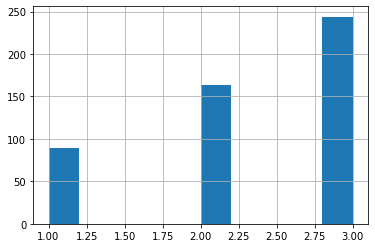

In [37]:
budget=final_dataframe.budget
budget.hist()
plt.show()

#### Budget Distribution
Restaurants in our sample size skew towards the more expensive side of the rating

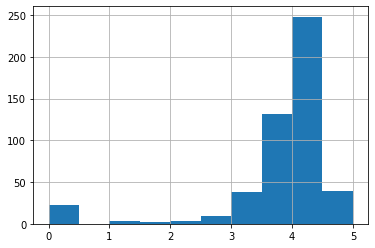

In [38]:
rating=(final_dataframe.rating)
rating.hist()
plt.show()

#### Rating Distribution
The bulk of the ratings are between 3.5 and 4.5

# Future Work:

I will be enriching this data further by attempting to collect the menus of all the restaurants. My hope is to find and use a relevant recipe dictionary to be able to figure out each restaurants ingredient requirements. 

Additionally, using the gep-cordinates, we want to be able to identify popular restaurants and ingredient demand per 1 sq. km grid in the city. Ultimately, I would be turning this project into a tool to help entrepreneurs decide the best restaurant type and locations for a new business. As well as assist restaurant suppliers to do more targeted sales.

In [39]:
pip freeze >> requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Refrences:
<li>
(2021) pandas documentation, Available at: https://pandas.pydata.org/docs/ (Accessed: 29th June 2021).
<li>
(2020) beautiful soup documentation, Available at: https://www.crummy.com/software/BeautifulSoup/bs4/doc/ (Accessed: 29th June 2021).
<li>
(2020) re documentation, Available at: https://docs.python.org/3/library/re.html (Accessed: 29th June 2021).    
<li>Keith Galli (Oct 1, 2020) Solving real world data science tasks with Python Beautiful Soup!, Available at: https://www.youtube.com/watch?v=Ewgy-G9cmbg&t=838s (Accessed: 29th June 2021).
</break>